<a href="https://colab.research.google.com/github/Sandeep0076/Model_deployment/blob/main/Image_classification_from_data_extraction_to_Kubernetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <Center>Image Classification of Anime protagonist using Fast AI

Mounted at /content/gdrive


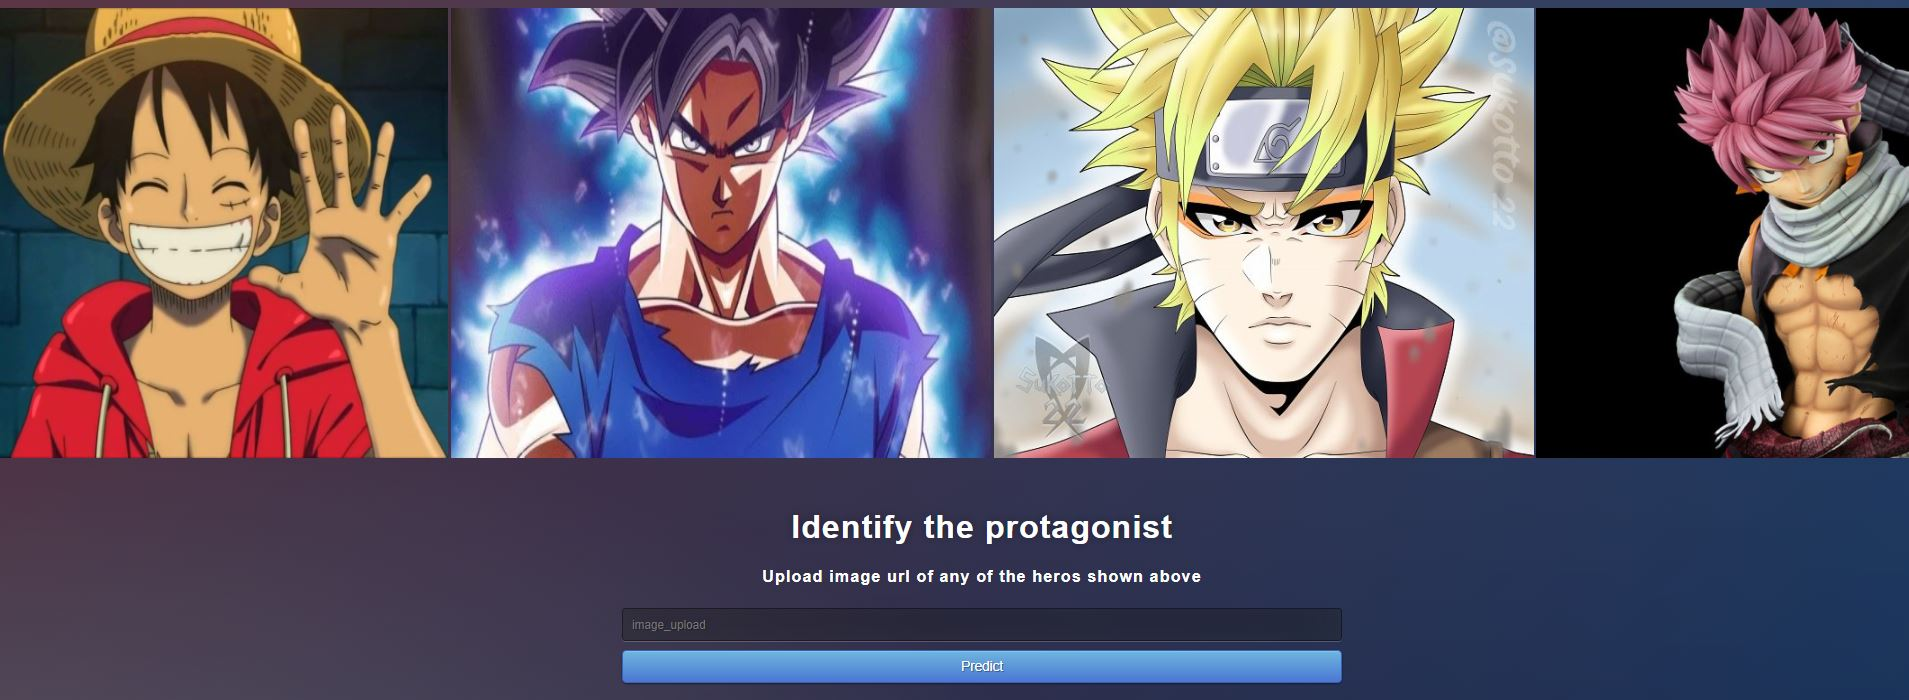

In [ ]:
#@title Webapp 
from google.colab import drive
drive.mount('/content/gdrive')
#@title Webapp 
from IPython.display import Image
Image('/content/gdrive/MyDrive/Data_science/Image_Classification/website.JPG')

# **Aim**


To build and deploy a web application where an image of anime character is  entered into a web-based form which then identifies the name.

For this, I created a image classification model from scratch and used **Kubernetes** for automating computer application deployment, scaling, and management.

Steps performed:

*   Downloaded image of 4 different anime protagonist(200 for each categories) and **created a custom dataset**.
*   Augmented the image to increase the size of the training set without acquiring new images.
*  Used pre-trained **ResNet18** Convolutional Neural Net model, and use **transfer learning**.
* **Trained** the model using **Fast AI** and hypertuned it.
* Evaluated and achieved the accuracy of 80% on validation dataset.
* Save the model and **deploy a machine learning pipeline with a Flask app** as a web service.
* **Build a Docker image** and upload it on **Google Container Registry** (GCR).





In [ ]:
#@title Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from fastai import *
from fastai.vision import *
import cv2
from fastai.metrics import error_rate
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/gdrive


In [ ]:
#@title Download images from net and create  a dataset
'''!pip install bing_image_downloader
from bing_image_downloader import downloader
downloader.download('naruto', limit=200)
downloader.download('luffy', limit=200)
downloader.download('natsu', limit=200)
downloader.download('goku', limit=200)'''

#### Number of elements in a list of path is same as number of classes you have


In [ ]:
path = Path('/content/gdrive/MyDrive/Data_science/Image_Classification/train/')
path.ls()

In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/Data_science/Images'

#shutil.move("path/to/current/file", "path/to/new/destination/for/file")

#### Data Loading For training

* Decide validation percentage ( 0.2 => 20% )
* Provide path for training data
* Decide augmentations criteria 
* Decide image size (which is 128 in my case)
* Test data can also be added but it's optional

In [ ]:
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train = '.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=128,
                                  num_workers=4).normalize(imagenet_stats)

#### Data Explorations

Our image dataset is stored  in 4 different folders, with each folder bearing the name of model of the images contained in the folder. I use the ImageDataBunch.from_folder() function to load the images and assign labels the images based on the name of the folder they’re read from.

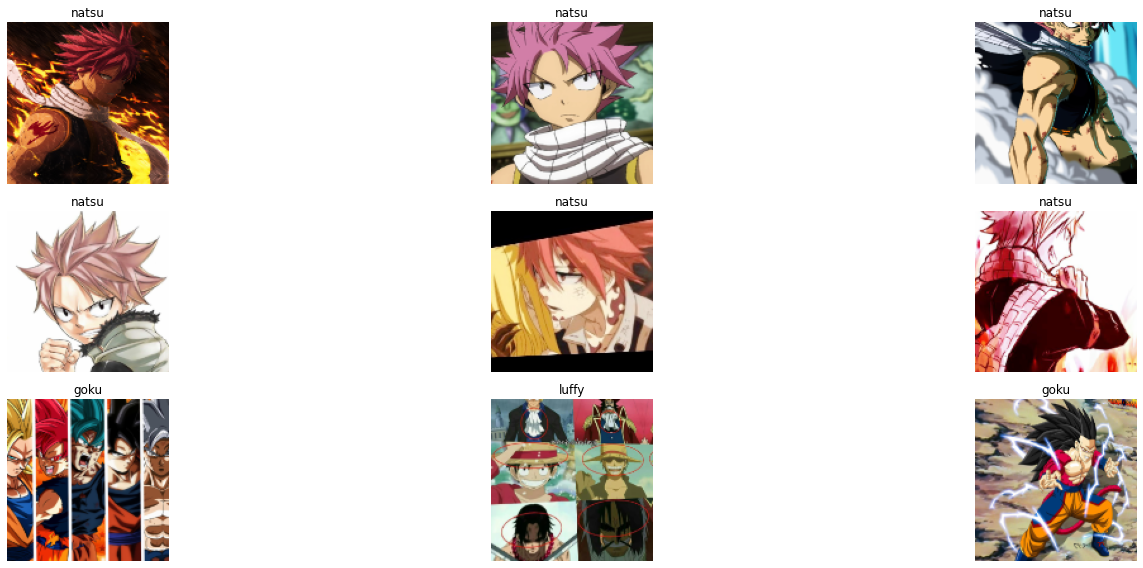

In [ ]:
data.show_batch(rows=3, figsize=(24,8), recompute_scale_factor=True)

### Print Classes present in the data

In [ ]:
data

ImageDataBunch;

Train: LabelList (436 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
naruto,naruto,naruto,naruto,naruto
Path: /content/gdrive/MyDrive/Data_science/Image_Classification/train;

Valid: LabelList (108 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
luffy,luffy,natsu,goku,goku
Path: /content/gdrive/MyDrive/Data_science/Image_Classification/train;

Test: None

In [ ]:
print(f'Name of the labels : {data.classes}')
print(f'Length of the training dataset :{len(data.train_ds)}')


Name of the labels : ['goku', 'luffy', 'naruto', 'natsu']
Length of the training dataset :436


### Create Model

I will use a pre-trained ResNet18 Convolutional Neural Net model, and use transfer learning to learn weights of only the last layer of the network.

In my case I manually collected the image dataset of around 800 images.So I use the create_cnn() function for loading a pre-trained ResNet18 network, that was trained on around a million images from the ImageNet database.

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], model_dir = Path(DATA_DIR),path = Path("."))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


### Finding LR

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


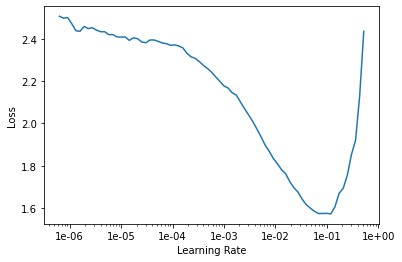

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestions=True)

### Train Model

In [ ]:
# Pick a value a bit before the minimum, where the loss still improves.
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(40,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,2.042013,3.695500,0.555556,00:28
1,1.691814,2.596827,0.601852,00:20
2,1.435375,2.220902,0.583333,00:19
3,1.287874,2.242458,0.601852,00:20
4,1.197496,1.758141,0.638889,00:19
5,1.134306,2.119853,0.620370,00:18
6,1.074437,2.452407,0.638889,00:20
7,1.043749,3.663504,0.611111,00:19
8,1.047498,3.886643,0.620370,00:18
9,1.087518,3.722617,0.611111,00:19


In [ ]:
# Hyper Parameter Tuning
learn.unfreeze()
learn.fit_one_cycle(20,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.179348,1.219872,0.787037,00:20
1,0.209553,1.167693,0.777778,00:19
2,0.182629,1.230080,0.796296,00:19
3,0.172747,1.172863,0.805556,00:20
4,0.167348,1.082868,0.796296,00:19
5,0.178952,1.554054,0.750000,00:19
6,0.175095,1.620877,0.750000,00:20
7,0.178799,1.636411,0.805556,00:19
8,0.177275,2.844236,0.805556,00:19
9,0.167891,1.454921,0.787037,00:20


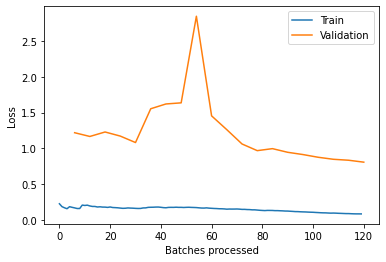

In [ ]:
learn.recorder.plot_losses()

### Interpret the results

Model performance can be validated in different ways. One of the popular methods is using the confusion matrix. Diagonal values of the matrix indicate correct predictions for each class, whereas other cell values indicate a number of wrong predictions.

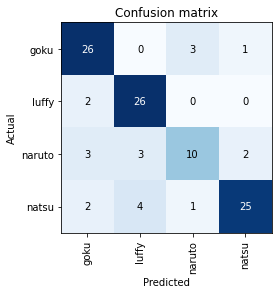

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

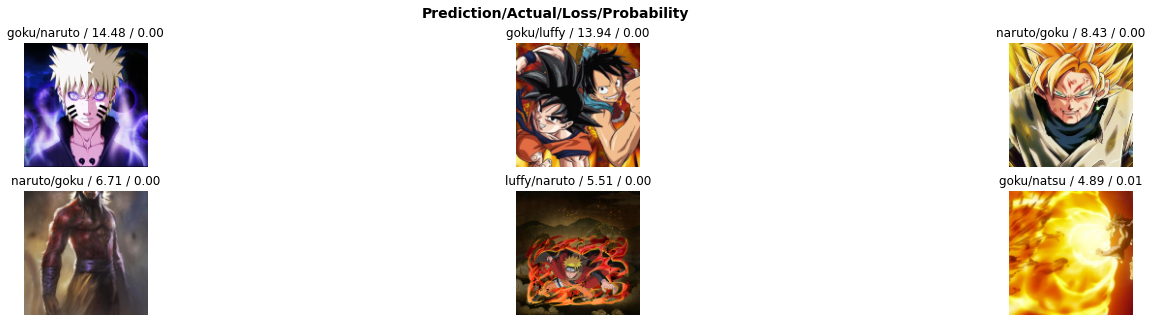

In [ ]:
interp.plot_top_losses(6,figsize = (25,5))

Second image has both goku and luffy and last 3 pictures are not very clear. on and all the results are satisfactory with accuracy on custom image dataset

5.2 Prediction Using Trained Model

In [ ]:
img = open_image('/content/gdrive/MyDrive/Data_science/Image_Classification/Naruto_newshot.png')
print(learn.predict(img)[0])

naruto


#### Save Model

In [ ]:

learn.export(file = Path("/content/gdrive/MyDrive/Data_science/Image_Classification/export.pkl"))
learn.model_dir = DATA_DIR
#learn.save("stage-1",return_path=True)

PosixPath('/content/gdrive/MyDrive/Data_science/Images/stage-1.pth')

### Load model

In [ ]:
def load_model():
    path = '/content/gdrive/MyDrive/Data_science/Image_Classification/'
    learn = load_learner(path, 'export.pkl')
    return learn
model = load_model()

In [ ]:
# extract image from url
import urllib.request

urllib.request.urlretrieve("http://3.bp.blogspot.com/-peDhNEIjzg0/VNejS_SfQYI/AAAAAAAAAJw/eGfKNFPUV1g/s1600/28824-monkey-luffy-one-piece-free-wallpapers.jpg", "local-filename.jpg")
img = open_image('local-filename.jpg')
print(model.predict(img)[1])

('local-filename.jpg', <http.client.HTTPMessage at 0x7fa7907e9850>)